#### install efficientent

In [1]:
import pandas as pd

In [1]:
%%capture
# install efficientnet to use pretrained
!pip3 install efficientnet_pytorch

#### First look at a dataset

In [38]:
df = pd.read_csv('path_to_dataset.csv')
df = df[['labels_words', 'image_path']]
df.head()

labels_words  \
0  Ломанная Импульс ИЗ Слово пересечение кольцо В...   
1  Ломанная Угол грань крупность параллельность т...   
2  Ломанная Многогранник куб ИЗ Плита Тавр N2 Пов...   
3  Ломанная Угол наконечник N2 асимметрия паралле...   
4  Ломанная Многогранник призма основание многоуг...   

                    image_path  
0  TMN/IMG/00/010/00010584.TIF  
1  TMN/IMG/00/027/00027434.TIF  
2  TMN/IMG/00/028/00028383.TIF  
3  TMN/IMG/00/028/00028552.TIF  
4  TMN/IMG/00/035/00035723.TIF

In [39]:
len(df)

719716

#### creating a vocabulary

In [ ]:
df1 = pd.read_csv('path_to_dataset_csv')
my_words_dict = {}
# add padding, start and end indices
my_words_dict['<pad>'] = 0
my_words_dict['<start>'] = 1
my_words_dict['<end>'] = 2
code = 3
for idx, i in df1.iterrows():
    for word in i['labels_words']:
        if word not in my_words_dict:
            my_words_dict[word] = code
            code+=1
print(code)

#### save vocabulary to json

In [ ]:
import json
# ensure_ascii=false because we use cyrillic characters
with open('path_to_vocabulary.json', 'w') as f:
    json.dump(my_words_dict, f, ensure_ascii=False)

#### apply conversion to all labels in dataframe

In [ ]:
def cvt_to_custom_idx(x):
    return ' '.join(['1']+[str(my_words_dict[i]) for i in x.split()]+['2'])
cvt_to_custom_idx('Ломанная Импульс ИЗ Слово пересечение кольцо')

In [ ]:
df1['labels'] = df1['labels'].apply(cvt_to_custom_idx)
df1.to_csv('path_to_dataset_csv', index=False)

In [3]:
# сломал siloiz_custom_labels
df1 = pd.read_csv('path_to_dataset.csv')
df1.head(5)

nser                                      custom_labels  \
0  10584                1 8 127 2017 2009 173 313 307 150 2   
1  27434        1 8 142 33 385 160 80 440 35 2018 125 427 2   
2  28383               1 8 152 153 2017 1485 137 170 1977 2   
3  28552  1 8 142 496 170 151 160 2019 138 129 2020 524 ...   
4  35723                     1 8 152 31 44 30 7 2021 2009 2   

                    image_path  
0  TMN/IMG/00/010/00010584.TIF  
1  TMN/IMG/00/027/00027434.TIF  
2  TMN/IMG/00/028/00028383.TIF  
3  TMN/IMG/00/028/00028552.TIF  
4  TMN/IMG/00/035/00035723.TIF

#### split train test and validation 60% 20% 20%


In [4]:
# from sklearn.model_selection import train_test_split

# df = pd.read_csv('path_to_dataset.py')
# y = df.custom_labels
# X = df.image_path

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
# X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)
# print(f'train set {len(y_train)} \n test set {len(y_test)}\n validation {len(y_val)} \n')

# df_train = pd.concat([X_train, y_train], axis=1)
# df_test = pd.concat([X_test, y_test], axis=1)
# df_val = pd.concat([X_val, y_val], axis=1)

# df_train.to_csv('path_to_dataset_train.py', index=False)
# df_test.to_csv('path_to_dataset_test.py', index=False)
# df_val.to_csv('path_to_dataset_val.py', index=False)

#### define a custom dataset and test if it works

##### we have 2 collates, 1 for training and 1 for generating all descriptors

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.data import Dataset, DataLoader
from typing import Union, Optional
from albumentations.core.composition import BaseCompose
from albumentations import BasicTransform
import pandas as pd
import numpy as np
import cv2
import albumentations as A
from pathlib import Path
from albumentations.pytorch import ToTensor
import torch.nn.functional as F

In [3]:
class ImageDataset(Dataset):
    # generic image dataset
    def __init__(self,
                 data_folder: str,
                 path_to_datalist: str,
                 transform: Union[BasicTransform, BaseCompose],
                 augment: Optional[Union[BasicTransform, BaseCompose]] = None,
                 grayscale: bool = False,
                 test_mode: Optional[bool] = False, ):
    
        self.data_folder = Path(data_folder)
        self.csv = pd.read_csv(self.data_folder / path_to_datalist)

        self.transform = transform
        self.augment = augment
        self.grayscale = grayscale
        self.test_mode = test_mode

        transform_targets = {'input': 'image'}
        self.transform_targets = transform_targets
        self.update_transform_targets(transform_targets)

    def update_transform_targets(self, transform_targets):
        self.transform.additional_targets = transform_targets
        self.transform.add_targets(transform_targets)
        if self.augment is not None:
            self.augment.additional_targets = transform_targets
            self.augment.add_targets(transform_targets)

    def apply_transform(self, transform, sample):
        new_sample = {}
        for source, target in self.transform_targets.items():
            if source in sample:
                new_sample[target] = sample[source]
        new_sample = transform(**new_sample)
        for source, target in self.transform_targets.items():
            if target in new_sample:
                sample[source] = new_sample[target]
        return sample

    def __getitem__(self, idx: int) -> dict:
        sample = self.get_raw(idx)
        sample = self.apply_transform(self.transform, sample)
        return sample

    def __len__(self) -> int:
        return len(self.csv)

    def get_raw(self, idx: int) -> dict:
        record = self.csv.iloc[idx]
        image = self.read_image(record)
        sample = {"input": image}

        if self.augment is not None:
            sample = self.apply_transform(self.augment, sample)

        if not self.test_mode:
            sample["target"] = record.label
        return sample

    def read_image(self, record) -> np.ndarray:
        image_path = self.data_folder / record.image_path
        image = cv2.imread(str(image_path), int(not self.grayscale))
        if image is None:
            raise ValueError(f'{image_path} image does not exist')
        if self.grayscale:
            image = image[..., None]
        else:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image


class ImageCaptionDataset(ImageDataset):
    # dataset for image captioning
    def get_raw(self, idx: int) -> dict:
        record = self.csv.iloc[idx]
        image = self.read_image(record)
        sample = {"input": image}
        if self.augment is not None:
            sample = self.apply_transform(self.augment, sample)

        if not self.test_mode:
            caption = [int(x) for x in record['custom_labels'].split()]
            sample['caption'] = caption
        else:
            sample['path'] = record['image_path']
        return sample

    # collate to dynamically pad captions
    @staticmethod
    def collate_fn(batch):
        captions = [torch.tensor(t['caption']) for t in batch]
        captions = torch.nn.utils.rnn.pad_sequence(captions, batch_first=True)
        input = torch.stack([t['input'] for t in batch])
        return {'input': input, 'captions': captions}
    
    @staticmethod
    def write_descrs_collate_fn(batch):
        input = torch.stack([t['input'] for t in batch])
        paths = [t['path'] for t in batch]
        return {'input': input, 'paths': paths}

In [44]:
mld = ImageCaptionDataset(
    data_folder='/workdir/tz', 
    path_to_datalist='path_to_dataset_train.csv',
    transform=A.Compose(
        [
            A.Resize(height=224,width=224),
            ToTensor(normalize={'mean':[0.5,0.5,0.5], 'std':[0.5,0.5,0.5]})
        ]
    )
)

mldataloader = DataLoader(mld, batch_size=32, collate_fn=ImageCaptionDataset.collate_fn)


mld_validation = ImageCaptionDataset(
    data_folder='/workdir/tz', 
    path_to_datalist='path_to_dataset_val.csv',
    transform=A.Compose(
        [
            A.Resize(height=224,width=224),
            ToTensor(normalize={'mean':[0.5,0.5,0.5], 'std':[0.5,0.5,0.5]})
        ]
    )
)

mldataloader_validation = DataLoader(mld_validation, batch_size=32, collate_fn=ImageCaptionDataset.collate_fn)

for i in mldataloader:
    for k,v in i.items():
        print(k,'\nshape of tensor is:',v.shape)
    for caption in i['captions']:
        print('caption', caption)
        break
    break

input 
shape of tensor is: torch.Size([32, 3, 224, 224])
captions 
shape of tensor is: torch.Size([32, 103])
caption tensor([   1,   25,  125,  437,  151, 2011,  509,  370,  384, 2014, 2009,  437,
         427,  141,  423,  426, 2031, 2002, 2009,  423, 2002,  125, 2031,    2,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0])


#### define a model

In [5]:
from efficientnet_pytorch import EfficientNet

class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        self.model = EfficientNet.from_pretrained(
            "efficientnet-b1",
            include_top=False,
            in_channels=3
        )

    def forward(self, images):
        features = self.model.forward(images)
        return features
    

class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_directions, encoder_dim, decoder_dim, teacher_forcing_ratio, drop_rate, num_layers=1):
        super(DecoderRNN, self).__init__()
        self.num_layers = num_layers
        self.num_directions = num_directions
        self.embedding_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        
        # teacher forcing ratio, I will be using 50% but it may be tuned
        self.teacher_forcing_ratio = teacher_forcing_ratio
        self.drop_rate = drop_rate

        # we get a feature vector here
        self.fc1 = nn.Linear(1280*1*1, self.embedding_dim)
        self.bn = nn.BatchNorm1d(self.embedding_dim, momentum=0.01)

        self.embed = nn.Embedding(self.vocab_size, self.embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(self.embedding_dim, self.hidden_dim, num_layers=self.num_layers, batch_first=True)
        self.fc_out = nn.Linear(self.hidden_dim, out_features=self.vocab_size)
        
    def forward_pool(self, feature_maps):
        if self.drop_rate > 0.:
            feature_maps = F.dropout(feature_maps, p=self.drop_rate, training=self.training)

        features = self.fc1(feature_maps.flatten(1))  # batch_size, embedding_size
        if self.drop_rate > 0.:
            features = F.dropout(features, p=self.drop_rate, training=self.training)
        return features

    def forward_loop(self, feature_maps, encoded_captions):
        features = self.forward_pool(feature_maps)
        use_teacher_forcing = True if random.random() < self.teacher_forcing_ratio else False

        if not use_teacher_forcing or not self.training:
            caption_token_ids = []
            # Without teacher forcing: use its own predictions as the next input
            batch_size, decode_length = encoded_captions.size(0), encoded_captions.size(1)  # batch_size, max_len
            decoder_input = features.unsqueeze(1) # or better to pass them as hidden?
            decoder_hidden = torch.zeros(self.num_layers*self.num_directions, batch_size, self.hidden_dim)
            decoder_hidden = decoder_hidden.type_as(feature_maps)
            decoder_outputs = None
            decoder_cell_state = torch.zeros(self.num_layers*self.num_directions, batch_size, self.hidden_dim)
            decoder_cell_state = decoder_cell_state.type_as(feature_maps)

            for di in range(decode_length):
                if di == 0:
                    decoder_output, (decoder_hidden, decoder_cell_state) = self.forward_no_embedding(decoder_input, (decoder_hidden, decoder_cell_state))

                else:
                    decoder_output, (decoder_hidden, decoder_cell_state) = self.forward(decoder_input, (decoder_hidden, decoder_cell_state))

                if decoder_outputs is None:
                    decoder_outputs = decoder_output
                else:
                    decoder_outputs = torch.cat((decoder_outputs.type_as(decoder_hidden), decoder_output.type_as(decoder_hidden)), dim=1) # dim=1 seqlen dimension

                outs_linear = self.fc_out(decoder_output.squeeze(1))
                _, predicted = outs_linear.max(1)
                caption_token_ids.append(predicted)
                decoder_input = predicted.unsqueeze(1)
        
            if self.training:
                out = self.fc_out(decoder_outputs)
            else:
                caption_token_ids = torch.stack(caption_token_ids, 1)
    
    
        else:
            ## Teacher forcing: Feed the target as the next input
            embeddings = self.embed(encoded_captions)
            embeddings = torch.cat((features.unsqueeze(1), embeddings), dim=1)
            hiddens, _ = self.lstm(embeddings)
            out = self.fc_out(hiddens[:, 1:, :])
            
        if self.training:
            return out.reshape(-1, out.shape[2])
        
        else:
            return caption_token_ids


    def forward(self, input, hidden):
        # input should be batchsize seqlen, do step by step so seqlen is 1
        hidden, cell_state = hidden[0], hidden[1]
        output = self.embed(input)
        output, hidden = self.lstm(output, (hidden, cell_state))
        return output, hidden

    def forward_no_embedding(self, input, hidden):
        hidden, cell_state = hidden[0], hidden[1]
        output, hidden = self.lstm(input, (hidden, cell_state))
        return output, hidden
    

class ImageCaptioningModel(nn.Module):
    def __init__(self, embed_dim = 256,decoder_dim = 256,vocab_size = 2037,num_directions = 1,hidden_dim = 256,encoder_dim = 1280,teacher_forcing_ratio = 0.5,drop_rate = 0.3):
        super(ImageCaptioningModel, self).__init__()
        self.enc = EncoderCNN()
        self.dec = DecoderRNN(
            embed_dim = embed_dim,
            decoder_dim = decoder_dim,
            vocab_size = vocab_size,
            num_directions = num_directions,
            hidden_dim = hidden_dim,
            encoder_dim = encoder_dim,
            teacher_forcing_ratio = teacher_forcing_ratio,
            drop_rate = drop_rate
        )        
        
        
    def forward(self, images, captions):
        feature_maps = self.enc.forward(images)
        outputs = self.dec.forward_loop(feature_maps, captions)
        return outputs
    
    def get_features(self, images):
        feature_maps = self.enc.forward(images)
        features = self.dec.fc1(feature_maps.flatten(1))
        return features
    
    def get_caption(self, images, maxlength=20):
        features = self.get_features(images)
        
        batch_size = images.shape[0]  # batch_size, max_len
        decoder_input = features.unsqueeze(1)
        decoder_hidden = torch.zeros(self.dec.num_layers*self.dec.num_directions, batch_size, self.dec.hidden_dim)
        decoder_hidden = decoder_hidden.type_as(features)
        decoder_outputs = None
        decoder_cell_state = torch.zeros(self.dec.num_layers*self.dec.num_directions, batch_size, self.dec.hidden_dim)
        decoder_cell_state = decoder_cell_state.type_as(features)
        caption_token_ids = []
        for di in range(maxlength):
            if di == 0:
                decoder_output, (decoder_hidden, decoder_cell_state) = self.dec.forward_no_embedding(decoder_input, (decoder_hidden, decoder_cell_state))
            else:
                decoder_output, (decoder_hidden, decoder_cell_state) = self.dec.forward(decoder_input, (decoder_hidden, decoder_cell_state))

            if decoder_outputs is None:
                decoder_outputs = decoder_output
            else:
                decoder_outputs = torch.cat((decoder_outputs.type_as(decoder_hidden), decoder_output.type_as(decoder_hidden)), dim=1) # dim=1 seqlen dimension

            outs_linear = self.dec.fc_out(decoder_output.squeeze(1))
            _, predicted = outs_linear.max(1)
            caption_token_ids.append(predicted)
            decoder_input = predicted.unsqueeze(1)
        caption_token_ids = torch.stack(caption_token_ids, 1)
        return caption_token_ids

#### check shapes and test loss

In [6]:
model = ImageCaptioningModel(
    embed_dim = 256,
    decoder_dim = 256,
    vocab_size = 2037,
    num_directions = 1,
    hidden_dim = 256,
    encoder_dim = 1280,
    teacher_forcing_ratio = 0.5,
    drop_rate = 0.3
)

model.to('cpu')
model.train()
import random
criterion = nn.CrossEntropyLoss(ignore_index=0)
for batch_idx, batch in enumerate(mldataloader):
    images, captions = batch['input'], batch['captions']
    model_out = model.forward(images, captions)
    model_featuers_out = model.get_features(images)
    generated_captions = model.get_caption(images)
    print('model output', model_out.shape)
    print('model get_features output', model_featuers_out.shape)
    print('generated captions', generated_captions[0])
    loss = criterion(model_out,captions.reshape(-1))
    print(loss)
    break

Loaded pretrained weights for efficientnet-b1
model output torch.Size([3296, 2037])
model get_features output torch.Size([32, 256])
generated captions tensor([ 396, 1721, 1023,    8, 1865, 1229, 1433, 1782,  390,  645, 1740, 1485,
        1122,  770, 1521, 1766,  529,   51,  204, 1451])
tensor(7.6223, grad_fn=<NllLossBackward>)


In [1]:
def val(model, val_loader):
#     model.train()
    model.eval()
    val_loss = 0
    correct = 0
    currlen = 0
    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader):
            images, captions = batch['input'], batch['captions']
            images = images.to(device)
            captions = captions.to(device)
            output = model.forward(images, captions)
            correct += output.eq(captions.view_as(output)).sum().item()
            currlen+=captions.flatten().shape[0]

    epoch_loss = running_loss / len(val_loader)
    return correct / currlen


print(val(model, mldataloader_validation))

#### Training loop

In [2]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

learning_rate = 1e-5
num_epochs = 100
losses = []
losses_val = []
step = 0
criterion = nn.CrossEntropyLoss(ignore_index=0)
params = list(model.parameters())
optimizer = optim.Adam(params, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
model.to(device)
model.train()


for epoch in range(num_epochs):

    running_loss = 0.0
    counter = 0
    dataloader = tqdm(enumerate(mldataloader), total=len(mldataloader), position=0, leave=True)
    for bathc_idx, (batch) in dataloader:
            images, captions = batch['input'], batch['captions']
            images = images.to(device)
            captions = captions.to(device)
            outputs = model.forward(images, captions)
#             features = enc.forward(images)
#             outputs = dec.forward_loop(features, captions)
#             print(features.shape)
#             print(outputs.shape)
            loss = criterion(outputs, captions.reshape(-1))
            model.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step(loss)
            
            running_loss += loss.item() * images.size(0)
            counter += 1
            dataloader.set_postfix(loss=(running_loss / (counter * mldataloader.batch_size)))
    epoch_loss = running_loss / len(mldataloader)
    losses_val.append(val(model, mldataloader_validation))[1]
    losses.append(epoch_loss)
    print('Training Loss: {:.4f}'.format(epoch_loss))
    torch.save(model.state_dict(), f'./models/{epoch}.pt')

#### Draw losses over epochs

In [57]:
import matplotlib.pyplot as plt

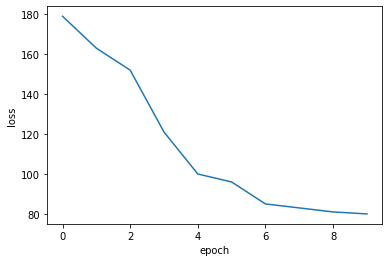

In [76]:
plt.plot(range(len(losses)), losses)
plt.ylabel('loss') #2.93
plt.xlabel('epoch')
plt.show()

#### example of generating caption
#### example of image and its caption

In [8]:
# make an instance of ImageCaptioningModel with the same config
trained_model = ImageCaptioningModel(
    embed_dim = 256,
    decoder_dim = 256,
    vocab_size = 2037,
    num_directions = 1,
    hidden_dim = 256,
    encoder_dim = 1280,
    teacher_forcing_ratio = 0.5,
    drop_rate = 0.3
)

trained_model.load_state_dict(torch.load('./models/last.pt'))

Loaded pretrained weights for efficientnet-b1
(0.05561312607944732, 644)


In [16]:
torch.cuda.empty_cache() 

In [22]:
# example of generating caption
# example of image and its caption

import json
with open('file_with_dictionary', 'r') as file:
        dict_e = json.load(file)
        dict_reversed = {value : key for (key, value) in dict_e.items()}

In [52]:
def get_words(caption, dict_reversed):
    result = []
    for i in caption:
        result.append(dict_reversed[int(i)])
    return ' '.join(result)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


generated caption 
 <start> <start> латынь N2 крупность латынь Слово латынь Слово Слово Буква Буква <end> <end> <end> Буква <end> Буква <end> Буква

 ground truth caption 
 <start> Слово П Р О Натура цвет N1 <end>


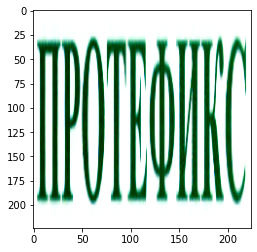

In [60]:
for sample in mld_validation:
#     print(sample)
    generated_caption = trained_model.get_caption(sample['input'].unsqueeze(0))
    print('generated caption \n', get_words(generated_caption[0], dict_reversed))
    print('\n ground truth caption \n', get_words(sample['caption'], dict_reversed))
    plt.imshow(sample['input'].permute(1, 2, 0))
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<start> Слово латынь О R G ОТЛ Буква N2 N I ножка N2 полоса длина вертикаль конец N2 изгиб дуга венец птица малость геометрия силуэт сидеть профиль СТ Язычок голова клюв поднимание СД глаз точка ФФ цвет N2 Синий Зелёный <end>


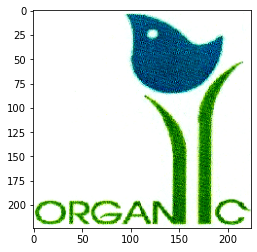

In [56]:
# get example from dataset
sample = mld_validation[10]
print(get_words(sample['caption'], dict_reversed))
plt.imshow(sample['input'].permute(1, 2, 0))

#### generating embeddings for every image in database and get images by query

In [105]:
from mpl_toolkits.axes_grid1 import ImageGrid

In [127]:
class ImgRetr():
    def __init__(self):
        self.model = None
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
    def load_model_jit(self, path):
        self.model = torch.jit.load(path)
        self.model = self.model.eval()
        self.model = self.model.to(self.device)

    def load_model_state_dict(self, path):
        self.model = ImageCaptioningModel(
        embed_dim = 256,
        decoder_dim = 256,
        vocab_size = 2037,
        num_directions = 1,
        hidden_dim = 256,
        encoder_dim = 1280,
        teacher_forcing_ratio = 0.5,
        drop_rate = 0.3
        )
        self.model.load_state_dict(torch.load(path))
        self.model = self.model.to(self.device)

    def save_jit(self, path):
        dummy_batch = torch.rand(2, 3, 224, 224, dtype=torch.float).to(self.device)
        self.model.forward = self.model.get_features
        traced = torch.jit.trace(self.model, dummy_batch)
        torch.jit.save(traced, path)
    
    def write_descriptors(self, dataloader):
        rowlist = []
        image_paths = []
        self.descriptors = None
        for batch_idx, batch in enumerate(tqdm(dataloader,total=len(dataloader))):
            x, z = batch["input"], batch['paths'][0]

            out = self.model.forward(x.to(self.device))
            if self.descriptors is not None:
                self.descriptors = torch.cat((self.descriptors, out), 0)
            else:
                self.descriptors = out
                
            image_paths.extend(z)
            
            if batch_idx % 1000 == 0:
                print(batch_idx)
        
        torch.save(self.descriptors, 'desctiprots_image_captioning.pt')
        df = pd.DataFrame(image_paths)
        df.to_csv('image_paths_project.csv', header=['paths'], index=False)
        
    def search(self, query, k=10):
        """query : torch.tensor of shape (256)"""
        cos_sim = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
        sim_tensor = cos_sim(query.to(self.device), self.descriptors)
        values, indices = torch.sort(sim_tensor, descending=True)
        image_paths_df = pd.read_csv('image_paths_project.csv')
        return image_paths_df.iloc[indices[:k].cpu()], values[:k]

    def read_image_to_tensor(self, image_path):
        image = self.read_image(image_path)
        image = ToTensor(normalize={'mean':[0.5,0.5,0.5], 'std':[0.5,0.5,0.5]})(image=image)['image']  
        image = image.to(self.device)
        return image
    
    def read_image(self, image_path):
        image = cv2.imread(str(image_path), int(True))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        transform = A.Resize(height=224, width=224)
        image = transform(image=image)['image']
        return image
            
    def draw_m_queries(self, m, k):
        # randomly sample m querries from databae, draw к closest
        self.df = pd.read_csv('path_to_csv_all_images')
        images = []
        for i in range(m):
            im_path = self.df.sample().iloc[0]['image_path']
            images.append(im_path)
        
        images_torch = [self.read_image_to_tensor(Path('base') / Path(x)) for x in images]
        images_np = [self.read_image(Path('base') / Path(x)) for x in images]
        my_batch = torch.stack(images_torch)
        out = self.model.forward(my_batch)
        for i, query in enumerate(out):
            print(f'query image {i, images[i]}')
            plt.imshow(images_np[i])
            plt.show()
            print('results using torch.nn.CosineSimilarity')
            images_to_draw_df, similarities_tensor = self.search(query.unsqueeze(0), k)
            fig = plt.figure(figsize=(20., 20.))
            images_to_draw = []
            idx = 0
            grid = ImageGrid(fig, 111,
                             nrows_ncols=(k//5, 5),
                             axes_pad=0.5,
                             )

            for ax, im in zip(grid, images_to_draw_df.iterrows()):              
                ax.imshow(self.read_image(Path('base') / Path(im[1].iloc[0])))
                print(im[1].iloc[0])
                images_to_draw.append(im[1].iloc[0])
                ax.set_title(float(similarities_tensor[idx]))
                idx+=1
            plt.show()

##### load checkpoint and save as jit trace

In [121]:
# ir = ImgRetr()
# ir.load_model_state_dict('./models/last.pt')
# ir.save_jit('./models/jit.pt')

##### load a jit trace

In [128]:
ir = ImgRetr()
ir.load_model_jit('jit.pt')

#### this is how we get descriptors for all images, it is really slow so we just load already made descriptors batch tensor

In [89]:
# mld_ir = ImageCaptionDataset(
#     data_folder='/workdir/tz', 
#     path_to_datalist='all_images_path_csv',
#     transform=A.Compose(
#         [
#             A.Resize(height=224,width=224),
#             ToTensor(normalize={'mean':[0.5,0.5,0.5], 'std':[0.5,0.5,0.5]})
#         ]
#     )
# )
# mld_ir.test_mode = True
# mldataloader_ir = DataLoader(mld_ir, batch_size=40, collate_fn=ImageCaptionDataset.write_descrs_collate_fn)

In [126]:
# for i in mldataloader_ir:
#     print(i['input'].shape)
#     break

##### load already computed descriptors for this demo, to save time

In [129]:
ir.descriptors = torch.load('desctiprots_image_captioning.pt')

In [130]:
ir.descriptors.shape

torch.Size([720007, 256])

query image (0, 'TMN/IMG/01/448/01448506.TIF')


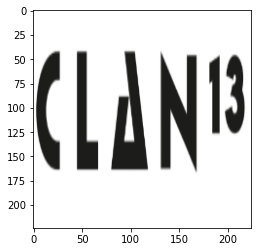

results using torch.nn.CosineSimilarity
TMN/IMG/01/448/01448506.TIF
TMN/IMG/00/320/00320090.TIF
TMN/IMG/01/206/01206862.TIF
TMN/IMG/01/217/01217391.TIF
TMN/IMG/00/806/00806745.TIF


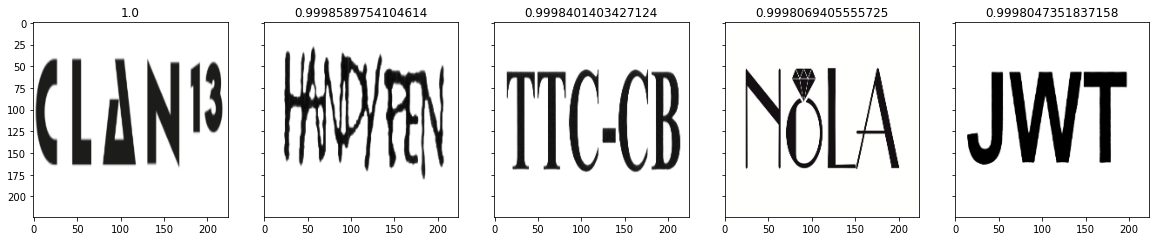

In [131]:
ir.draw_m_queries(1,5)